# CBA (Confidence-Based Autonomy)
## An Online and Interactive Confidence-Based Imitation Learning Algorithm

<img src="https://raw.githubusercontent.com/FredAmouzgar/ImitationLearning/main/imgs/CBA.png" width=700>

Source: CBA paper <a href="https://www.aaai.org/Papers/JAIR/Vol34/JAIR-3401.pdf">Interactive Policy Learning through Confidence-Based Autonomy</a>

<img src="https://raw.githubusercontent.com/FredAmouzgar/ImitationLearning/main/imgs/CBA2.png" width=700>
Source: <a href="https://arxiv.org/abs/1811.06711">An Algorithmic Perspective on Imitation Learning</a>

## Defining the CBA agents' Neural Networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import time, random, gym
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make("LunarLander-v2")
print(env.unwrapped, "environment started ...")

# reset the environment
state = env.reset()
print("Init state:", state)

# number of actions
action_size = env.action_space.n

# Init the state space and finding its size
state_size = env.observation_space.shape[0]

class Network(nn.Module):
    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        super(Network, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Builds a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class LearnerNetwork(nn.Module):
    def __init__(self, state_size, action_size): #, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        super(LearnerNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Builds a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

<LunarLander<LunarLander-v2>> environment started ...
Init state: [-2.5072097e-04  1.4074726e+00 -2.5412774e-02 -1.5322576e-01
  2.9734275e-04  5.7563586e-03  0.0000000e+00  0.0000000e+00]


## The Expert Class

In [2]:
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        # Agent's Network
        self.brain = Network(state_size, action_size).to(device)

    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.brain.eval()
        with torch.no_grad():
            action_values = self.brain(state)
        self.brain.train()

        action = np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
        action = np.int32(action)
        return action

## Loading the Expert and Initializing the Learner

In [3]:
# Init our expert
expert = Agent(state_size=state_size, action_size=action_size)
# Loading expert's brain
expert.brain.load_state_dict(torch.load('LunarLander_Expert.pth'))
print("Expert loaded ...")

learner = LearnerNetwork(state_size=state_size, action_size=action_size).to(device)
print("Learner initialized ...")

Expert loaded ...
Learner initialized ...


## A function that tests an agent

In [4]:
def test_agent(agent, env, epochs=1, render=True):
    max_t = 5000
    for i_episode in range(epochs):
        state = env.reset()
        score = 0
        for t in range(max_t):
            env.render() if render else ""
            time.sleep(0.01)
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = agent(state)
            action = np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
            next_state, reward, done, _ = env.step(action)
            score += reward
            state = next_state
            if done:
                break
        #print(f"Score:{score}")
    env.close() # closing the environment
    return score

## Testing the Expert

In [5]:
test_agent(agent=expert.brain, env=env, epochs=1)

254.30821254550548

## Testing the untrained agent

In [6]:
test_agent(agent=learner, env=env, epochs=1)

-99.00829101815975

## Implementing CBA
<img src="https://raw.githubusercontent.com/FredAmouzgar/ImitationLearning/main/imgs/CBA2.png" width=500>

In [7]:
def train_learner(learner, X, y, optim):
    loss_fn = nn.CrossEntropyLoss()
    train_dataset = TensorDataset(X, y)
    loss_sum = 0
    dataloader = DataLoader(train_dataset, batch_size=64)
    for x_batch, y_batch in dataloader:
        predictions = learner(x_batch)
        loss = loss_fn(predictions, y_batch)
        loss_sum += loss
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_sum / X.shape[0]  # returning average loss

def collect_initial_expert_data(env, expert, N=20000, threshold=250, device="cuda"):
    state = env.reset()
    score = 0
    temp_states, states = [], torch.FloatTensor()
    temp_actions, actions = [], torch.Tensor()
    for t in range(N):
        temp_states.append(state)
        expert_action = expert.act(state)
        temp_actions.append(expert_action)

        next_state, reward, done, _ = env.step(expert_action)
        score += reward
        state = next_state
        if done:
            env.reset()
            if score > threshold:
                temp_states, temp_actions = torch.tensor(temp_states), torch.tensor(temp_actions)
                states = torch.cat((states, temp_states))
                actions = torch.cat((actions, temp_actions))
                temp_states, temp_actions = [], []
    if len(temp_states) > 0:
        temp_states, temp_actions = torch.tensor(temp_states), torch.tensor(temp_actions)
        states = torch.cat((states, temp_states))
        actions = torch.cat((actions, temp_actions))
    return states.to(device), actions.to(torch.long).to(device)

## Initializing Learner's Policy by collecting 20k trajectories from the Expert (pure supervised learning)

In [8]:
D_states, D_actions = collect_initial_expert_data(env, expert, N=20000)
print("Collected Data shapes: states:{0}, actions:{1}".format(D_states.shape, D_actions.shape))
optimizer = torch.optim.Adam(learner.parameters(), lr=0.001)
loss = train_learner(learner, X=D_states, y=D_actions, optim=optimizer)
print("Initial Loss=", loss)

Collected Data shapes: states:torch.Size([20000, 8]), actions:torch.Size([20000])
Initial Loss= tensor(0.0177, device='cuda:0', grad_fn=<DivBackward0>)


## Testing the learner after the policy initialization

In [9]:
test_agent(agent=learner, env=env, epochs=1)

-430.63911473816967

## Interactively training the agent based on its confidence

In [9]:
T = 5000  # @param ['1000', '5000']
N = 25  # @param ['20', '25']
C = 0.8  # @param ['0.5', '0.9'] 
learner_best_score = None
testing_scores, losses = [], []
expert_no_actions, learner_no_actions = [], []

episode_loop = tqdm(range(1, N + 1), desc="Episode 0 | Avg Score: None", leave=False)
for i in episode_loop:
    state = env.reset()
    score = 0
    episode_loop.set_description_str('Episode {} | Training ...'.format(i))
    states, actions = [], []
    expert_action_counter, learner_action_counter = 0, 0
    for t in range(T):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        learner.eval()
        with torch.no_grad():
            action_values = learner(state)
        learner.train()
        # Finding the best action that we have the highest confidence about.
        if torch.max(F.softmax(action_values, dim=1), dim=1)[0].item() <= C: # if less than C let the expert do it
            expert_action_counter += 1
            expert_action = expert.act(state.cpu().data.numpy())
            action = expert_action
            states.append(state.cpu().numpy())
            actions.append(action)
        else:
            learner_action_counter += 1
            action = np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
            
        next_state, reward, done, _ = env.step(action)
        score += reward
        state = next_state
        if done:
            env.reset()
    states = torch.tensor(states).squeeze().to(device)
    actions = torch.tensor(actions).to(torch.long).squeeze().to(device)
    D_states = states if D_states==None else torch.cat([D_states, states])
    D_actions = actions if D_actions==None else torch.cat([D_actions, actions])
    loss = train_learner(learner, X=D_states, y=D_actions, optim=optimizer)
    losses.append(loss)
    
    expert_no_actions.append(expert_action_counter), learner_no_actions.append(learner_action_counter)
    episode_loop.set_description_str('Episode {} | loss: {:.3f} | ExpAct = {} | LearnAct ={} | Testing ...'.format(i, loss,
                                                                                                                   expert_action_counter,
                                                                                                                   learner_action_counter))
    
    score = test_agent(agent=learner, env=env, epochs=1)
    if learner_best_score and score > learner_best_score:
        torch.save(learner, "cba_agent.pth")
    learner_best_score = score if not None or score > learner_best_score else learner_best_score
    testing_scores.append(score)
    
    episode_loop.set_description_str('Episode {} | loss: {:.3f}| Test score: {:.3f}'.format(i, loss, score))
    time.sleep(2)
env.close() # closing the environment

## Plotting the Loss, Testing Rewards, and Number of actions taken by both agents

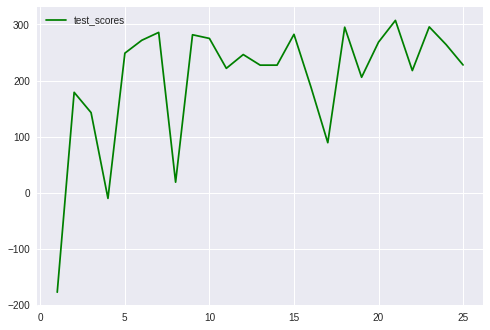

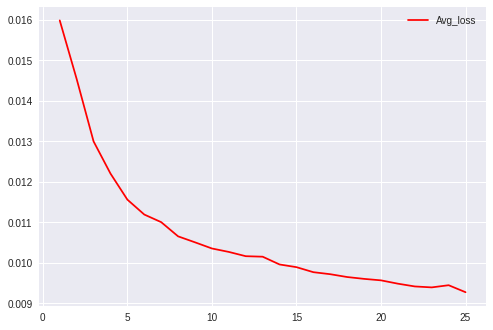

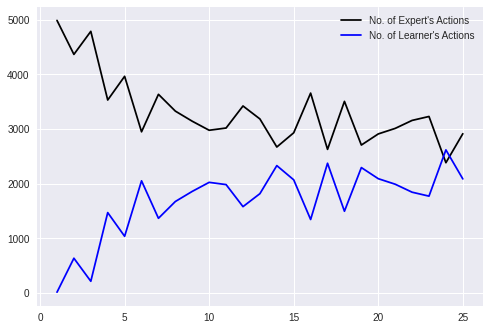

In [10]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

losses, testing_scores = np.array(losses), np.array(testing_scores)
expert_no_actions, learner_no_actions = np.array(expert_no_actions), np.array(learner_no_actions)

plt.plot(range(1,len(testing_scores)+1), testing_scores, label="test_scores", color="green")
plt.legend()
plt.show()

plt.plot(range(1,len(losses)+1), losses, label="Avg_loss", color="red")
plt.legend()
plt.show()

plt.plot(range(1,len(expert_no_actions)+1), expert_no_actions, label="No. of Expert's Actions", color="black")
plt.plot(range(1,len(expert_no_actions)+1), learner_no_actions, label="No. of Learner's Actions", color="blue")
plt.legend()
plt.show()

## Let's test the Learner

In [11]:
print("Learner's Performance\n-----------")
for i in range(5):
    reward = test_agent(agent=learner, env=env, render=True)
    print(reward, end="\t")

Learner's Performance
-----------
272.87503751868474	253.4278558214665	206.8154267735759	278.08881970306277	246.70221904436553	

## The Final Performance of the Learner and its Comparison to the Expert

In [12]:
collect_stats_iters = 200

In [13]:
learner = torch.load("cba_agent.pth")

expert_res, learner_res = [], []
print("Examining Learner\n-----------")
for i in tqdm(range(collect_stats_iters)):
    reward = test_agent(agent=learner, env=env, render=False)
    learner_res.append(reward)
    #print(reward, end="\t")

    
print("Examining Expert-----------")
for i in tqdm(range(collect_stats_iters)):
    reward = test_agent(agent=expert.brain, env=env, render=False)
    expert_res.append(reward)
    #print(reward, end="\t")
    
learner_res = np.array(learner_res)
expert_res = np.array(expert_res)


print("Learner Mean:", learner_res.mean(), "Learner std:", learner_res.std())
print("Expert Mean:", expert_res.mean(), "Expert std:", expert_res.std())

  0%|          | 0/200 [00:00<?, ?it/s]

Examining Learner
-----------


  0%|          | 0/200 [00:00<?, ?it/s]

Examining Expert-----------


100%|██████████| 200/200 [11:51<00:00,  3.56s/it]

Learner Mean: 251.42062527949238 Learner std: 62.258536027004695
Expert Mean: 255.08344299533834 Expert std: 52.89260008040917


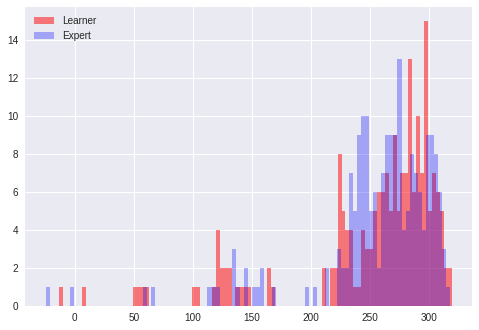

In [14]:
import matplotlib.pyplot as plt

plt.hist(learner_res, bins=100, label="Learner", alpha=0.5, color="red")
plt.hist(expert_res, bins=100, label="Expert", alpha=0.3, color="blue")
plt.legend()
plt.show()

<hr>